In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.datasets import make_regression
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsClassifier
from sk_modelcurves.learning_curve import draw_learning_curve
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/Users/rogeliozuniga/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


### Describe the content of the dataset and its goals
The dataset is made up of all numerical data of a subset of medical data relating to patient diagnosis for diabetes according to WHO criteria.

The goal of the dataset is to try and determine possible feature importance to forecast diabetes for this specific population, females at least 21 years old of Pima Indian heritage.

There are some missing values for some of the data variables.

In [3]:
col_names = ['times_pregnant','glucose_concentration','blood_pressure','skin_fold_thickness','serum_insulin','bmi','pedigree','age','class']
na={"glucose_concentration" : "0", "blood_pressure" : "0", "skin_fold_thickness" : "0", "serum_insulin" : "0", "bmi" : "0"}
pima_data = pd.read_csv('pima-indians-diabetes/pima-indians-diabetes.data', names=col_names, na_values=na)

### Describe the features and formulate a hypothesis on which might be relevant in predicting diabetes

After doing basic data exploration, looking at the correlation values and the counts it seems to me that glucose_concentration and bmi are the most helpful features in predicting diabetes, at least according to this dataset, on the surface you would think that skin_fold_thickness would be closely related to bmi but we have a lot of null values there.Also, insulin would seem to be related to glucose_concentration but we have even more null values for that feature

In [4]:
print("CRUDE 'AUTO' DATA DICTIONARY:")
for nextColumn in col_names:
    fromTo = 'either' if nextColumn == 'class' else 'from'
    orTo = 'or' if nextColumn == 'class' else 'to'
    print("- {0}: {1} {2} {3} {4} ".format(nextColumn,fromTo,pima_data[nextColumn].min(),orTo,pima_data[nextColumn].max()))

CRUDE 'AUTO' DATA DICTIONARY:
- times_pregnant: from 0 to 17 
- glucose_concentration: from 44.0 to 199.0 
- blood_pressure: from 24.0 to 122.0 
- skin_fold_thickness: from 7.0 to 99.0 
- serum_insulin: from 14.0 to 846.0 
- bmi: from 18.2 to 67.1 
- pedigree: from 0.078 to 2.42 
- age: from 21 to 81 
- class: either 0 or 1 


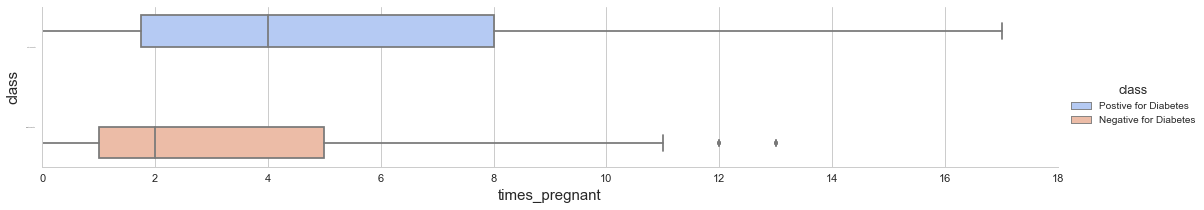

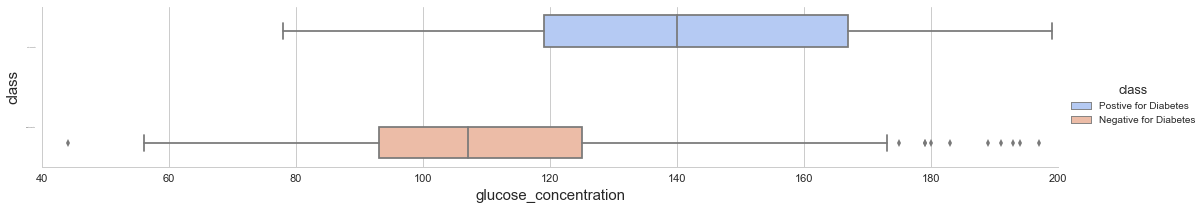

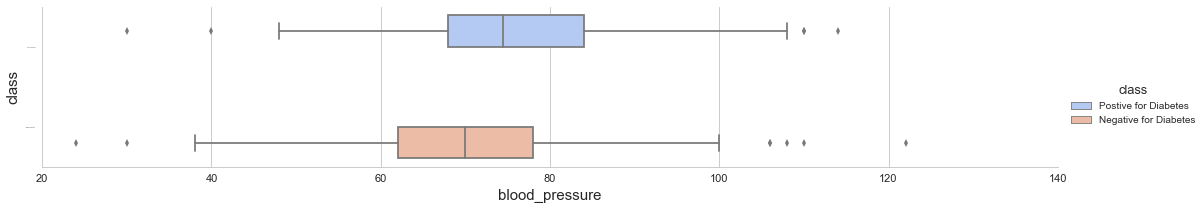

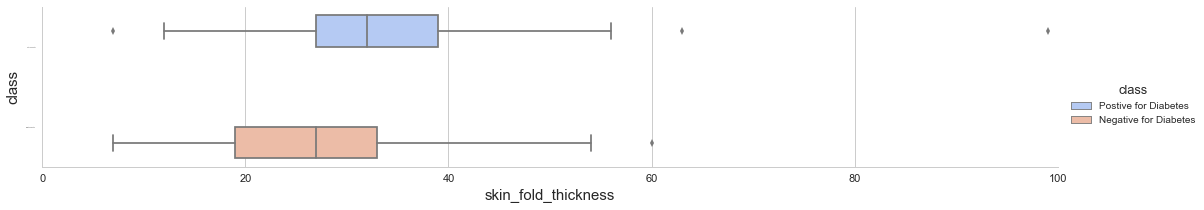

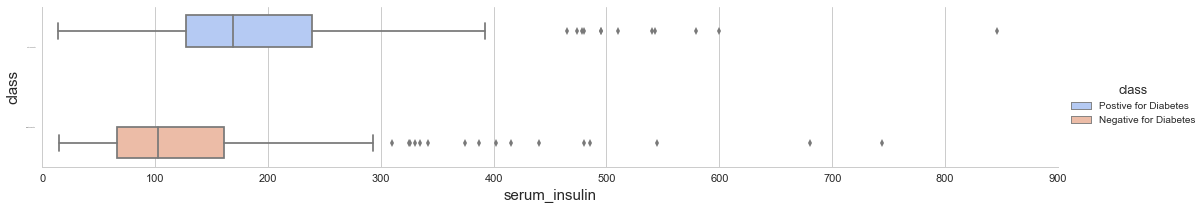

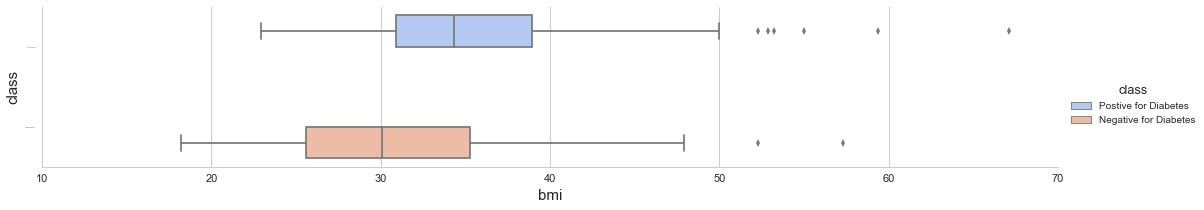

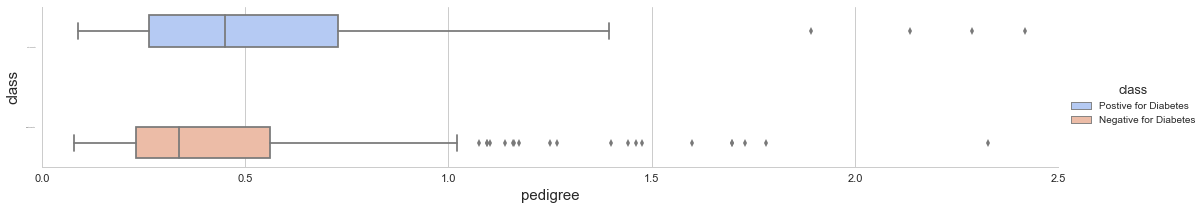

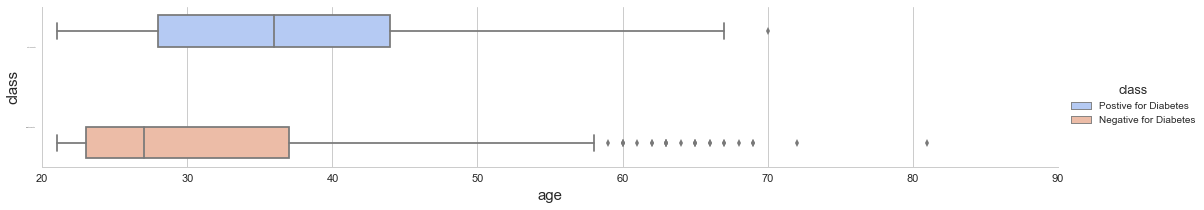

In [5]:
sns.set_style("whitegrid")
sns.set_context(rc={'ytick.labelsize': 0.0,'axes.labelsize': 15.0,'axes.titlesize': 10.0,'xtick.labelsize': 11.0})
pima_data_vis = pima_data.replace({'class':{0:'Negative for Diabetes',1:'Postive for Diabetes'}})
for nextFeature in pima_data.columns:
    if nextFeature != 'class':
        sns.factorplot(x=nextFeature, y="class", hue="class",legend=True ,data=pima_data_vis, kind="box",
                       size=3, aspect=5, palette="coolwarm", orient="h");

In [6]:
pima_data.describe()

,times_pregnant,glucose_concentration,blood_pressure,skin_fold_thickness,serum_insulin,bmi,pedigree,age,class
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [7]:
pima_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768 entries, 0 to 767
Data columns (total 9 columns):
times_pregnant           768 non-null int64
glucose_concentration    763 non-null float64
blood_pressure           733 non-null float64
skin_fold_thickness      541 non-null float64
serum_insulin            394 non-null float64
bmi                      757 non-null float64
pedigree                 768 non-null float64
age                      768 non-null int64
class                    768 non-null int64
dtypes: float64(6), int64(3)
memory usage: 60.0 KB


In [8]:
pima_data.corr().sort('class', ascending=False)

,times_pregnant,glucose_concentration,blood_pressure,skin_fold_thickness,serum_insulin,bmi,pedigree,age,class
class,0.221898,0.494650,0.170589,0.259491,0.303454,0.313680,0.173844,0.238356,1.000000
glucose_concentration,0.128135,1.000000,0.223192,0.228043,0.581186,0.232771,0.137246,0.267136,0.494650
bmi,0.021719,0.232771,0.289230,0.648214,0.228050,1.000000,0.155382,0.025841,0.313680
serum_insulin,0.082171,0.581186,0.098272,0.184888,1.000000,0.228050,0.130395,0.220261,0.303454
skin_fold_thickness,0.100239,0.228043,0.226839,1.000000,0.184888,0.648214,0.115016,0.166816,0.259491
age,0.544341,0.267136,0.330107,0.166816,0.220261,0.025841,0.033561,1.000000,0.238356
times_pregnant,1.000000,0.128135,0.214178,0.100239,0.082171,0.021719,-0.033523,0.544341,0.221898
pedigree,-0.033523,0.137246,-0.002805,0.115016,0.130395,0.155382,1.000000,0.033561,0.173844
blood_pressure,0.214178,0.223192,1.000000,0.226839,0.098272,0.289230,-0.002805,0.330107,0.170589


### Describe the missing/NULL values. Decide if you should impute or drop them and justify your choice.

As we can see from info() below we have very FEW missing values in glucose_concentration, blood_pressure and bmi, but we have a significant number of values missing for skin_fold_thickness and serum_insulin

    DROP serum_insulin
Most medical literature seems to describe a direct relationship between insulin levels and glucose concentration in the blood in both type I and type II diabetes, therefore I am going to drop serum_insulin since it most likely will not have significant impact as a predictor

https://vsearch.nlm.nih.gov/vivisimo/cgi-bin/query-meta?v%3Aproject=medlineplus&v%3Asources=medlineplus-bundle&query=Type+2+diabetes

https://www.nlm.nih.gov/medlineplus/ency/article/000305.htm

    IMPUTE skin fold thickness

After taking a quick look at some literature on BMI/SFT measurements as predictors of diabetes in adults (there is a lot more study being conducted for children and adolescents!) I have a weak idea that the verdict is out on which is a more effective predictor, they are both used, sometimes together, so I am choosing to impute skin fold thickness and fill in the missing data with the mean

    IMPUTE glucose_concentration, blood_pressure and bmi
  
These have very few missing values so I will fill them with the mean for each

In [204]:
pima_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768 entries, 0 to 767
Data columns (total 9 columns):
times_pregnant           768 non-null int64
glucose_concentration    763 non-null float64
blood_pressure           733 non-null float64
skin_fold_thickness      541 non-null float64
serum_insulin            394 non-null float64
bmi                      757 non-null float64
pedigree                 768 non-null float64
age                      768 non-null int64
class                    768 non-null int64
dtypes: float64(6), int64(3)
memory usage: 60.0 KB


In [5]:
pima_data.drop('serum_insulin',1, inplace=True)
pima_data
pima_data.replace({'skin_fold_thickness':{np.nan:pima_data['skin_fold_thickness'].mean()}},inplace=True)
pima_data.replace({'blood_pressure':{np.nan:pima_data['blood_pressure'].mean()}},inplace=True)
pima_data.replace({'bmi':{np.nan:pima_data['bmi'].mean()}},inplace=True)
pima_data.replace({'glucose_concentration':{np.nan:pima_data['glucose_concentration'].mean()}},inplace=True)

In [206]:
pima_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768 entries, 0 to 767
Data columns (total 8 columns):
times_pregnant           768 non-null int64
glucose_concentration    768 non-null float64
blood_pressure           768 non-null float64
skin_fold_thickness      768 non-null float64
bmi                      768 non-null float64
pedigree                 768 non-null float64
age                      768 non-null int64
class                    768 non-null int64
dtypes: float64(5), int64(3)
memory usage: 54.0 KB


### Come up with a benchmark for the minimum performance that an algorithm should have on this dataset

In [113]:
scoreboard = {}

In [107]:
y = pima_data['class']
X = pima_data.drop('class', axis=1)
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

from sklearn.dummy import DummyClassifier
dc = DummyClassifier(strategy='most_frequent')
dummy_timeit = %timeit -o dc.fit(X_train, y_train)
dummy_score = dc.score(X_train,y_train)

10000 loops, best of 3: 76.8 µs per loop


In [114]:
scoreboard['Dummy'] = {'timeit':dummy_timeit,'score':dummy_score}

In [30]:
dummy_score

0.65635179153094458

    Minimum performance to beat is ~ .66 which is as good as just guessing that everyone has diabetes 

In [24]:
from sklearn.cross_validation import ShuffleSplit
cv = ShuffleSplit(X_train.shape[0], n_iter=10, test_size=0.2, random_state=0)

### What's the best performance you can get with kNN? Is kNN a good choice for this dataset?

In [142]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=17, weights='distance', p=1)
knn_timeit = %timeit -o knn_model.fit(X_train, y_train)

1000 loops, best of 3: 538 µs per loop


In [63]:
knn_model.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_neighbors': 17,
 'p': 1,
 'weights': 'distance'}

In [130]:
from sklearn.grid_search import GridSearchCV
parameters = {'n_neighbors': range(1,30), 'weights': ['uniform', 'distance'],'p': range(1,4)}
clf_knn = GridSearchCV(knn_model, parameters, cv=cv)
clf_knn.fit(X_train, y_train)
clf_knn.best_params_

{'n_neighbors': 17, 'p': 1, 'weights': 'distance'}

In [143]:
knn_score = knn_model.score(X_test, y_test)
scoreboard['Knn'] = {'timeit':knn_timeit,'score':knn_score}

In [144]:
knn_score

0.75974025974025972

In [355]:
knn2_model = KNeighborsClassifier(n_neighbors=13, weights='distance', p=1)
knn2_timeit = %timeit -o knn2_model.fit(X_train, y_train)
knn2_score = knn2_model.score(X_test, y_test)
scoreboard['Knn2'] = {'timeit':knn2_timeit,'score':knn2_score}

1000 loops, best of 3: 550 µs per loop


In [356]:
knn2_score

0.79220779220779225

    The best Knn can do is ~ .76 which is better than the benchmark value. I think Knn is a good choice because similar cases of diabetes will have similar observed feature values and that's when Knn is good, I am only concerned about outliers in the dataset
    
    Strangely enough, although GridSearchCV decided n_neighbors=17 was optimimal, I tried it with 13 (because easy_learning_curves wanted 13 max!) and that gave me a better score ~ .79  (WTF?!)

### What's the best performance you can get with Naive Bayes? Is NB a good choice for this dataset?

In [145]:
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB(alpha=12)
nb_timeit = %timeit -o nb_model.fit(X_train, y_train)

1000 loops, best of 3: 656 µs per loop


In [64]:
nb_model.get_params()

{'alpha': 12, 'class_prior': None, 'fit_prior': True}

In [32]:
parameters = {'alpha': range(1,30)}
clf_nb = GridSearchCV(nb_model,parameters,cv=cv)
clf_nb.fit(X_train, y_train)
clf_nb.best_params_

{'alpha': 12}

In [146]:
nb_score = nb_model.score(X_test,y_test)
scoreboard['NB'] = {'timeit':nb_timeit,'score':nb_score}

In [147]:
nb_score

0.74025974025974028

    The best NB can do is ~ .74 which is better than benchmark but not as good as Knn. NM is probably not going to be a good fit for this dataset because the parameters are correlated which is something NB ignores

### What's the best performance you can get with Logistic Regression? Is LR a good choice for this dataset?

In [148]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(C=13,penalty='l2',max_iter=27)
lr_timeit = %timeit -o lr_model.fit(X_train, y_train)

100 loops, best of 3: 3.43 ms per loop


In [57]:
lr_model.get_params()

{'C': 4,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'penalty': 'l1',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0}

In [60]:
parameters = {'C': range(1,30),'max_iter': range(1,30),'penalty':['l1','l2']}
clf_lr = GridSearchCV(lr_model,parameters,cv=cv)
clf_lr.fit(X_train, y_train)
clf_lr.best_params_

{'C': 13, 'max_iter': 27, 'penalty': 'l2'}

In [149]:
lr_score = lr_model.score(X_test,y_test)
scoreboard['LR'] = {'timeit':lr_timeit,'score':lr_score}

In [150]:
lr_score

0.77922077922077926

    The best LR can do is ~ .78 which is much better than benchmark and better than Knn.

### What's the best performance you can get with Random Forest? Is RF a good choice for this dataset?

In [151]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators = 146)
rf_timeit = %timeit -o rf_model.fit(X_train, y_train)

10 loops, best of 3: 128 ms per loop


In [61]:
rf_model.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 146,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [43]:
parameters = {'n_estimators': range(1,200)}
clf_rf = GridSearchCV(rf_model,parameters,cv=cv)
clf_rf.fit(X_train, y_train)
clf_rf.best_params_

{'n_estimators': 146}

In [152]:
rf_score = rf_model.score(X_test,y_test)
scoreboard['RF'] = {'timeit':rf_timeit,'score':rf_score}

In [153]:
rf_score

0.79220779220779225

    The best RF can do is ~ .79 which is slightly better than LR at a much higher wall-clock cost.
    I think that ramdom forest is a good fit for this dataset since it handles outliers well and is also good at handling corelated features

### If you could only choose one, which classifer from the above that you already ran is best? How do you define best? (hint: could be prediction accuracy, running time, interpretability, etc)

    If I could use only one I would go with LR because, in this case it has the correct combination of being easy to interpret (as a linear regression for classification is very easy to explain), has a much lower wall-clock cost (37 times faster) and gets about the same results as the best performer in terms of accuracy score, RF.

In [154]:
scoreboard

{'Dummy': {'score': 0.65635179153094458,
  'timeit': <TimeitResult : 10000 loops, best of 3: 76.8 µs per loop>},
 'Knn': {'score': 0.75974025974025972,
  'timeit': <TimeitResult : 1000 loops, best of 3: 538 µs per loop>},
 'LR': {'score': 0.77922077922077926,
  'timeit': <TimeitResult : 100 loops, best of 3: 3.43 ms per loop>},
 'NB': {'score': 0.74025974025974028,
  'timeit': <TimeitResult : 1000 loops, best of 3: 656 µs per loop>},
 'RF': {'score': 0.79220779220779225,
  'timeit': <TimeitResult : 10 loops, best of 3: 128 ms per loop>}}

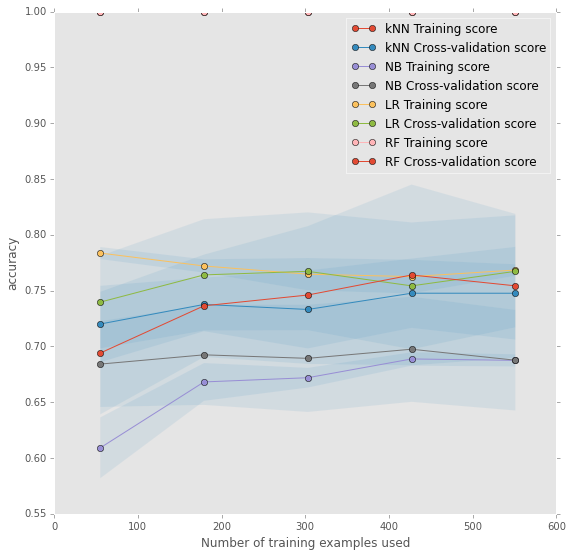

In [155]:
draw_learning_curve([knn_model, nb_model, lr_model, rf_model], X_train, y_train, estimator_titles=['kNN', 'NB', 'LR', 'RF'], cv=10, scoring='accuracy')
fig = plt.gcf()
fig.set_size_inches(9, 9)

In [78]:
from sklearn.cross_validation import cross_val_score
knn_scores = cross_val_score(knn_model, X_test, y_test, scoring='f1', cv=10)
print('CV accuracy {}, Average accuracy {}'.format(knn_scores, knn_scores.mean()))

CV accuracy [ 0.66666667  0.83333333  0.75        0.61538462  0.90909091  0.72727273
  0.8         0.57142857  0.44444444  0.44444444], Average accuracy 0.676206571207


In [79]:
nb_scores = cross_val_score(nb_model, X_test, y_test, scoring='f1', cv=10)
print('CV accuracy {}, Average accuracy {}'.format(nb_scores, nb_scores.mean()))

CV accuracy [ 0.71428571  0.92307692  0.92307692  0.61538462  0.72727273  0.5         0.8
  0.57142857  0.54545455  0.44444444], Average accuracy 0.676442446442


In [80]:
lr_scores = cross_val_score(lr_model, X_test, y_test, scoring='f1', cv=10)
print('CV accuracy {}, Average accuracy {}'.format(lr_scores, lr_scores.mean()))

CV accuracy [ 0.61538462  0.72727273  0.90909091  0.83333333  0.90909091  0.5         0.5
  0.5         0.44444444  0.5       ], Average accuracy 0.643861693862


In [81]:
rf_scores = cross_val_score(rf_model, X_test, y_test, scoring='f1', cv=10)
print('CV accuracy {}, Average accuracy {}'.format(rf_scores, rf_scores.mean()))

CV accuracy [ 0.66666667  0.72727273  0.61538462  0.57142857  1.          0.57142857
  0.6         0.57142857  0.44444444  0.5       ], Average accuracy 0.626805416805


In [86]:
from sklearn.metrics import classification_report
print("KNN")
print classification_report(knn_model.predict(X_test), y_test)
print("Logistic Regression")
print classification_report(lr_model.predict(X_test), y_test)
print("Naive Bayes")
print classification_report(nb_model.predict(X_test), y_test)
print("Ramdom Forest")
print classification_report(rf_model.predict(X_test), y_test)

KNN
             precision    recall  f1-score   support

          0       0.89      0.77      0.82       112
          1       0.54      0.74      0.63        42

avg / total       0.79      0.76      0.77       154

Logistic Regression
             precision    recall  f1-score   support

          0       0.89      0.79      0.83       109
          1       0.60      0.76      0.67        45

avg / total       0.80      0.78      0.79       154

Naive Bayes
             precision    recall  f1-score   support

          0       0.82      0.78      0.80       103
          1       0.60      0.67      0.63        51

avg / total       0.75      0.74      0.74       154

Ramdom Forest
             precision    recall  f1-score   support

          0       0.86      0.81      0.83       103
          1       0.65      0.73      0.69        51

avg / total       0.79      0.78      0.78       154

